IA & Data science (LU3IN0226) -- 2024-2025
--------
*&copy; Equipe pédagogique: Christophe Marsala, Olivier Schwander, Jean-Noël Vittaut.*

# TD-TME07: les arbres de décision (catégoriel)

L'objectif de ce notebook est d'implémenter un algorithme d'apprentissage supervisé qui travaille sur des données catégorielles, l'algorithme de construction d'arbres de décision.


<font size="+1" color="RED"><b>[Q]</b></font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

ZHANG Yuxiang & LECOMTE Antoine

<font color="RED" size="+1"><b>[Q]</b></font> **Renommer ce notebook**

Tout en haut de cette page, cliquer sur <tt>tme-07</tt> et rajouter à la suite de <tt>tme-07</tt> les noms des membres du binômes séparés par un tiret.

<font color="RED" size="+1">IMPORTANT: soumission de votre fichier final</font>

**Nom à donner au fichier à poster** : *tme-07-Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme
- ne pas compresser ou faire une archive: il faut rendre le fichier ipython tel quel, éventuellement, si vous avez d'autres fichiers vous les rendez séparément.

**Echancier pour la soumission de votre compte-rendu:**
- le compte-rendu d'une séance doit être remis obligatoirement <font color="RED">avant la séance suivante</font>.

**Le compte-rendu est soumis sur la page Moodle.**

In [1]:
# - - - - - - - - - - - - - - - - - -
# imports utiles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mtpl
%matplotlib inline  

import math
import time
import sys

# Les instructions suivantes sont utiles pour recharger automatiquement 
# le code modifié dans les librairies externes
%load_ext autoreload
%autoreload 2

# - - - - - - - - - - - - - - - - - -
# Information sur l'environnent utilisé ici:
print("Version python et des librairies:")
print("\tPython ",sys.version)
print("\tpandas: ",pd.__version__)
print("\tnumpy: ",np.__version__)
print("\tmatplotlib: ",mtpl.__version__)

Version python et des librairies:
	Python  3.9.6 (default, Nov 11 2024, 03:15:38) 
[Clang 16.0.0 (clang-1600.0.26.6)]
	pandas:  2.2.3
	numpy:  2.0.2
	matplotlib:  3.9.4


In [2]:
# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')   # iads doit être dans le répertoire père du répertoire courant !

# Importation de la librairie iads
import iads as iads

# importation de Classifiers
from iads import Classifiers as classif

# importation de utils
from iads import utils as ut

# importation de evaluation
from iads import evaluation as ev



In [3]:
# Chargement des fichiers de données :

elections_df = pd.read_csv("data/elections.csv")
elections_df

,Adresse,Majeur?,Nationalite,Label
0,Paris,oui,Francais,1
1,Paris,non,Francais,-1
2,Montpellier,oui,Italien,1
3,Paris,oui,Suisse,-1
4,Strasbourg,non,Italien,-1
5,Strasbourg,non,Francais,-1
6,Strasbourg,oui,Francais,1
7,Montpellier,oui,Suisse,-1


In [4]:
# Pour ne garder que le nom des variables de description (et pas la classe):
# sous la forme d'une liste:

elections_noms = [nom for nom in elections_df.columns if nom != 'Label']

# Passer du dataframe à des arrays:
elections_desc = np.array(elections_df[elections_noms])
elections_label = np.array(elections_df['Label'])

print("Noms des features: ",elections_noms)

Noms des features:  ['Adresse', 'Majeur?', 'Nationalite']


In [5]:
elections_label[elections_desc[:,0] == "Paris"]

array([ 1, -1, -1])

## Premières fonctions: entropie et classe majoritaire

<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction <code>classe_majoritaire</code> qui, étant donné un array de labels rend la classe majoritaire (celle qui est possédée par le plus grand nombre d'exemples donc...). En cas d'égalité, cette fonction rend la première classe rencontrée.

**Remarque :** on utilise la fonction numpy `unique` qui permet d'obtenir les valeurs différentes d'un array ainsi que leur décompte.

In [6]:
# Exemple d'utilisation de la fonction numpy `unique`

valeurs, nb_fois = np.unique(elections_label,return_counts=True)

print("Valeurs différentes dans l'array           : ",valeurs)
print("Décompte de chaque valeur (respectivement) : ",nb_fois)

Valeurs différentes dans l'array           :  [-1  1]
Décompte de chaque valeur (respectivement) :  [5 3]


In [7]:
def classe_majoritaire(Y):
    """ Y : (array) : array de labels
        rend la classe majoritaire ()
    """
    valeurs, nb_fois = np.unique(Y, return_counts=True)
    index_max = np.argmax(nb_fois)
    return valeurs[index_max]

In [8]:
#Vérification sur nos données:
classe_majoritaire(elections_label)

np.int64(-1)

### Entropie et gain d'information

<div class="alert alert-block alert-warning">
    
On note $\{c_1, c_2,..., c_k\}$, l'ensemble des valeurs de classes possibles dans un ensemble $Y$.

On note $p_1$ la probabilité de la classe $c_1$ parmi $Y$, etc., et on note $P=(p_1, p_2,..., p_k)$ la distribution de probabilités sur les classes (on a $\sum_{i=1}^{k} p_i =1$ et $p_i \in [0,1]$ pour tout $i$).

L'**entropie de Shannon** de la distribution $P$ est donnée par:

$ H_S(P) = -\sum_{i=1}^{k} p_i \log_k(p_i)$

Le logarithme utilisé est le logarithme en base $k$ afin d'obtenir une valeur comprise entre $0$ et $1$ de l'entropie. 
</div>

Pour ce qui suit, une *distribution de probabilités* est représentée par une **liste** Python $P=[p_1,...,p_k]$ de valeurs réelles telle que
* pour tout $i=1,..., k$ : $0 \leq p_i \leq 1$
* $\sum_{i=1}^{k}p_i = 1$

<font color="RED" size="+1">**[Q]**</font> 
Ecrire la fonction `shannon` qui, étant donné une distribution de probabilités $P$ rend la valeur de $H_S(P)$, l'entropie de Shannon de la distribution asociée à $P$.

La **base du log** à utiliser est donnée par le nombre d'éléments dans $P$.


<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction `shannon` qui, étant donné une distribution de probabilités $P$ fournie sous la forme d'une liste de nombres, rend la valeur de $H_S(P)$, l'entropie de Shannon de $P$.

In [9]:
def shannon(P):
    """ list[Number] -> float
        Hypothèse: P est une distribution de probabilités
        - P: distribution de probabilités
        rend la valeur de l'entropie de Shannon correspondante
    """
    ########################## COMPLETER ICI 
    k = len(P)  # base du logarithme
    
    # Cas particulier : k = 1 (entropie nulle)
    if k == 1:
        return 0.0
    
    entropy = 0.0
    
    for p in P:
        if p > 0:  # ignorer si p = 0 (terme = 0)
            entropy += p * math.log(p, k)  # log en base k
    
    return -entropy
    
    ##########################
    

In [10]:
# Exemples d'utilisation:
print("H([1]) = ", shannon([1]))

print("\nH([1,0]) = ", shannon([1, 0]))

print("\nH([0.25, 0.25, 0.25, 0.25]) = ", shannon([0.25, 0.25, 0.25, 0.25]))

print("\nH([0.7, 0.1, 0.2, 0.0]) = ", shannon([0.7, 0.1, 0.2, 0.0]))

print("\nH([1.0/3, 2.0/3]) = ", shannon([1.0/3, 2.0/3]))



H([1]) =  0.0

H([1,0]) =  -0.0

H([0.25, 0.25, 0.25, 0.25]) =  1.0

H([0.7, 0.1, 0.2, 0.0]) =  0.5783898247235197

H([1.0/3, 2.0/3]) =  0.9182958340544896


<font color="RED" size="+1">**[Q]**</font> Tracer, à l'aide de la fonction `plot`, la courbe donnant la valeur de `shannon([p, 1-p])` en fonction de `p`.

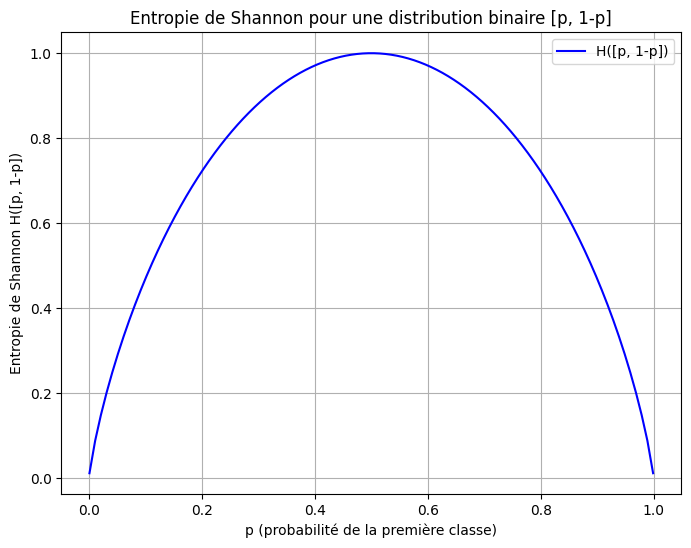

In [11]:
# Création des valeurs de p entre 0 et 1 (excluant les bords pour éviter log(0))
p_values = np.linspace(0.001, 0.999, 100)  # 100 points entre 0.001 et 0.999
entropy_values = [shannon([p, 1-p]) for p in p_values]

# Tracé de la courbe
plt.figure(figsize=(8, 6))
plt.plot(p_values, entropy_values, label="H([p, 1-p])", color='blue')
plt.xlabel('p (probabilité de la première classe)')
plt.ylabel('Entropie de Shannon H([p, 1-p])')
plt.title('Entropie de Shannon pour une distribution binaire [p, 1-p]')
plt.grid(True)
plt.legend()
plt.show()

<font color="RED" size="+1">**[Q]**</font> A l'aide de la fonction <code>shannon</code>, écrire la fonction <code>entropie</code> qui prend un ensemble de labels en argument et renvoie l'entropie de la distribution des classes dans cet ensemble.

In [12]:
def entropie(Y):
    """ Y : (array) : ensemble de labels de classe
        rend l'entropie de l'ensemble Y
    """
    # Calcul des fréquences de chaque classe
    valeurs, counts = np.unique(Y, return_counts=True)
    total = len(Y)
    P = counts / total  # Distribution de probabilité
    
    return shannon(P)

In [13]:
# Exemple sur nos données :
print("Entropie de ", elections_label,": ",entropie(elections_label))

print("Entropie de ", elections_label[0:4],": ",entropie(elections_label[0:4]))

Entropie de  [ 1 -1  1 -1 -1 -1  1 -1] :  0.9544340029249649
Entropie de  [ 1 -1  1 -1] :  1.0


## Arbres de décision

Dans cette partie, on réalise l'implémentation de l'algorithme de construction d'un arbre de décision.

### Représentation d'un arbre en Python

<div class="alert alert-block alert-warning">
Pour représenter un arbre en Python, on a besoin de définir une structure de données adéquate. 

Un arbre de décision est défini par des **noeuds** qui sont de 2 types :
- *noeud interne* : c'est un noeud qui est associé à un attribut (ie. une feature de description des exemples) et qui possède des fils qui sont aussi des noeuds. 
- *feuille* : c'est un noeud qui est associé à un label de la classe et qui a la particularité de ne pas avoir de descendants.
</div>

Pour représenter des noeuds, nous définissons la classe `NoeudCategoriel` suivante:

In [14]:
# La librairie suivante est nécessaire pour l'affichage graphique de l'arbre:
import graphviz as gv

# Eventuellement, il peut être nécessaire d'installer graphviz sur votre compte:
# pip install --user --install-option="--prefix=" -U graphviz

class NoeudCategoriel:
    """ Classe pour représenter des noeuds d'un arbre de décision
    """
    def __init__(self, num_att=-1, nom=''):
        """ Constructeur: il prend en argument
            - num_att (int) : le numéro de l'attribut auquel il se rapporte: de 0 à ...
              si le noeud se rapporte à la classe, le numéro est -1, on n'a pas besoin
              de le préciser
            - nom (str) : une chaîne de caractères donnant le nom de l'attribut si
              il est connu (sinon, on ne met rien et le nom sera donné de façon 
              générique: "att_Numéro")
        """
        self.attribut = num_att    # numéro de l'attribut
        if (nom == ''):            # son nom si connu
            self.nom_attribut = 'att_'+str(num_att)
        else:
            self.nom_attribut = nom 
        self.Les_fils = None       # aucun fils à la création, ils seront ajoutés
        self.classe   = None       # valeur de la classe si c'est une feuille
        
    def est_feuille(self):
        """ rend True si l'arbre est une feuille 
            c'est une feuille s'il n'a aucun fils
        """
        return self.Les_fils == None
    
    def ajoute_fils(self, valeur, Fils):
        """ valeur : valeur de l'attribut de ce noeud qui doit être associée à Fils
                     le type de cette valeur dépend de la base
            Fils (NoeudCategoriel) : un nouveau fils pour ce noeud
            Les fils sont stockés sous la forme d'un dictionnaire:
            Dictionnaire {valeur_attribut : NoeudCategoriel}
        """
        if self.Les_fils == None:
            self.Les_fils = dict()
        self.Les_fils[valeur] = Fils
        # Rem: attention, on ne fait aucun contrôle, la nouvelle association peut
        # écraser une association existante.
    
    def ajoute_feuille(self,classe):
        """ classe: valeur de la classe
            Ce noeud devient un noeud feuille
        """
        self.classe    = classe
        self.Les_fils  = None   # normalement, pas obligatoire ici, c'est pour être sûr
        
    def classifie(self, exemple):
        """ exemple : numpy.array
            rend la classe de l'exemple 
            on rend la valeur None si l'exemple ne peut pas être classé (cf. les questions
            posées en fin de ce notebook)
        """
        if self.est_feuille():
            return self.classe
        if exemple[self.attribut] in self.Les_fils:
            # descente récursive dans le noeud associé à la valeur de l'attribut
            # pour cet exemple:
            return self.Les_fils[exemple[self.attribut]].classifie(exemple)
        else:
            # Cas particulier : on ne trouve pas la valeur de l'exemple dans la liste des
            # fils du noeud... Voir la fin de ce notebook pour essayer de résoudre ce mystère...
            print('\t*** Warning: attribut ',self.nom_attribut,' -> Valeur inconnue: ',exemple[self.attribut])
            return None
    
    def compte_feuilles(self):
        """ rend le nombre de feuilles sous ce noeud
        """
        if self.est_feuille():
            return 1
        total = 0
        for noeud in self.Les_fils:
            total += self.Les_fils[noeud].compte_feuilles()
        return total
     
    def to_graph(self, g, prefixe='A'):
        """ construit une représentation de l'arbre pour pouvoir l'afficher graphiquement
            Cette fonction ne nous intéressera pas plus que ça, elle ne sera donc pas expliquée            
        """
        if self.est_feuille():
            g.node(prefixe,str(self.classe),shape='box')
        else:
            g.node(prefixe, self.nom_attribut)
            i =0
            for (valeur, sous_arbre) in self.Les_fils.items():
                sous_arbre.to_graph(g,prefixe+str(i))
                g.edge(prefixe,prefixe+str(i), valeur)
                i = i+1        
        return g


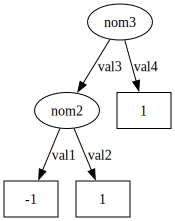

In [15]:
# Exemple d'utilisation: 
un_noeud0= NoeudCategoriel() 
un_noeud0.ajoute_feuille(-1)

un_noeud1= NoeudCategoriel()
un_noeud1.ajoute_feuille(+1)

un_noeud2= NoeudCategoriel(42,"nom2")
un_noeud2.ajoute_fils("val1",un_noeud0)
un_noeud2.ajoute_fils("val2",un_noeud1)

un_noeud3 = NoeudCategoriel(11,"nom3")
un_noeud3.ajoute_fils("val3",un_noeud2)

un_noeud4= NoeudCategoriel() 
un_noeud4.ajoute_feuille(1)
un_noeud3.ajoute_fils("val4",un_noeud4)

# L'affichage se fait en 2 temps
# 1) on initialise un graphe orienté :
gtree = gv.Digraph(format='png')
# 2) on le rempli en appelant la méthode de la classe NoeudCategoriel
un_noeud3.to_graph(gtree)

### Construction de l'arbre de décision

<div class="alert alert-block alert-warning">
Comme on l'a vu dans le cours, pour construire un arbre de décision à partir d'un dataset ($X$, $Y$), il faut réaliser les étapes suivantes:
    
1. calculer l'entropie de Shannon de l'ensemble des classes $Y$, on la note $H_S(Y)$.
    
2. si $H_S(Y)$ est inférieure à epsilon (qui est un réel positif donné en paramètre de l'algorithme), alors construire une feuille avec cet ensemble, la classe associée à cette feuille est la classe majoritaire dans $Y$.
    
3. sinon, pour chaque attribut $X_j$ qui décrit les exemples de $X$,
    
    3.1. pour chacune des valeurs $v_{jl}$ de $X_j$ construire l'ensemble des exemples de $X$ qui possède la valeur $v_{jl}$ ainsi que l'ensemble de leurs labels.
    
    3.2. calculer l'entropie conditionnelle de Shannon de la classe relativement à l'attribut $X_j$. On note $H_S(Y|X_j)$ cette entropie    
    
4. l'attribut $X_{best}$ qui **maximise le gain d'information** est choisi pour constituer un nouveau noeud $\eta$ de l'arbre de décision:
    
    4.1. chaque valeur de $X_{best}$ est utilisée pour décomposer ($X$, $Y$) en autant de datasets que $X_{best}$ possède de valeurs: chaque dataset est séparant $X$ et $Y$ selon la valeur prise pour $X_{best}$. 
    
    4.2. pour chaque dataset obtenu on reprend en 1 pour construire chacun des fils de $\eta$. 


On rappelle que le gain d'information est:

$$I_S(X_j,Y) = H_S(Y) - H_S(Y|X_j)$$

**Remarque**: si le gain d'information est nul pour tous les attributs, alors on arrête la décomposition et on construit une feuille avec cet ensemble en donnant la classe majoritaire comme étiquette à cette feuille.
</div>

<font color="RED" size="+1">**[Q]**</font> Compléter la fonction `construit_AD`suivante afin qu'elle permette de construire un arbre de décision. Cette fonction rend un `NoeudCategoriel` qui correspond à l'arbre construit pour le dataset $(X,Y)$ donné.

In [16]:
import numpy as np

def construit_AD(X, Y, epsilon, LNoms=[]):
    """ 
    X,Y : dataset
    epsilon : seuil d'entropie pour le critère d'arrêt 
    LNoms : liste des noms de features (colonnes) de description 
    """
    
    entropie_ens = entropie(Y)
    if entropie_ens <= epsilon:
        # ARRET : on crée une feuille
        noeud = NoeudCategoriel(-1, "Label")
        noeud.ajoute_feuille(classe_majoritaire(Y))
        return noeud

    # Initialisation pour trouver le meilleur attribut
    min_entropie = float('inf')
    i_best = -1
    Xbest_valeurs = None
    
    # Parcours de tous les attributs
    for i in range(X.shape[1]):
        valeurs = np.unique(X[:, i])  # Valeurs distinctes de l'attribut
        entropie_cond = 0.0
        
        for v in valeurs:
            Y_v = Y[X[:, i] == v]
            if len(Y_v) > 0:
                p = len(Y_v) / len(Y)
                entropie_cond += p * entropie(Y_v)
        
        # Mise à jour du meilleur attribut
        if entropie_cond < min_entropie:
            min_entropie = entropie_cond
            i_best = i
            Xbest_valeurs = valeurs
    
    # Si aucun attribut n'apporte un gain d'information
    if i_best == -1:
        noeud = NoeudCategoriel(-1, "Label")
        noeud.ajoute_feuille(classe_majoritaire(Y))
        return noeud
    
    # Création du noeud avec le meilleur attribut
    nom_attribut = LNoms[i_best] if LNoms else ''
    noeud = NoeudCategoriel(i_best, nom_attribut)
    
    # Vérification que Xbest_valeurs n'est pas vide
    if Xbest_valeurs is None:
        return noeud
    
    # Ajout des fils pour chaque valeur de l'attribut
    for v in Xbest_valeurs:
        X_v = X[X[:, i_best] == v, :]  # Assurer que X_v reste en 2D
        Y_v = Y[X[:, i_best] == v]

        # Vérifier que l'ensemble n'est pas vide avant l'appel récursif
        if len(Y_v) > 0:
            noeud.ajoute_fils(v, construit_AD(X_v, Y_v, epsilon, LNoms))

    return noeud


La classe pour implémenter un arbre de décision dérive de la classe `Classifier`. Elle utilise la fonction `construit_AD` dans sa méthode `train` pour construire un arbre à partir d'un dataset donné.

<font color="RED" size="+1">**[Q]**</font> Compléter la classe suivante en donnant le code des méthodes `train` et `predict`.

**Remarque :** la méthode `score` ne fera rien dans notre cas, on verra dans un autre notebook comment on pourrait la définir.

In [17]:
class ClassifierArbreDecision(classif.Classifier):
    """ Classe pour représenter un classifieur par arbre de décision
    """
    
    def __init__(self, input_dimension, epsilon, LNoms=[]):
        """ Constructeur
            Argument:
                - intput_dimension (int) : dimension de la description des exemples
                - epsilon (float) : paramètre de l'algorithme (cf. explications précédentes)
                - LNoms : Liste des noms de dimensions (si connues)
            Hypothèse : input_dimension > 0
        """
        classif.Classifier.__init__(self,input_dimension)  # Appel du constructeur de la classe mère
        self.epsilon = epsilon
        self.LNoms = LNoms
        # l'arbre est manipulé par sa racine qui sera un Noeud
        self.racine = None
        
    def toString(self):
        """  -> str
            rend le nom du classifieur avec ses paramètres
        """
        return 'ClassifierArbreDecision ['+str(self.dimension) + '] eps='+str(self.epsilon)
        
    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        self.racine = construit_AD(desc_set, label_set, self.epsilon, self.LNoms)
    
    def score(self, x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        # cette méthode ne fait rien dans notre implémentation :
        pass
    
    def predict(self, x):
        """ x (array): une description d'exemple
            rend la prediction sur x             
        """
        if self.racine is None:
            raise ValueError("L'arbre n'a pas été entraîné")
        return self.racine.classifie(x)

    def number_leaves(self):
        """ rend le nombre de feuilles de l'arbre
        """
        return self.racine.compte_feuilles()
    
    def draw(self, GTree):
        """ affichage de l'arbre sous forme graphique
            Cette fonction modifie GTree par effet de bord
        """
        if self.racine:
            self.racine.to_graph(GTree)

### Premières expérimentations

Apprentissage d'un arbre de décision avec la base sur les élections :

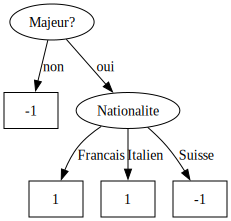

In [18]:
# Initialiation d'un arbre pour le dataset Elections:
arbre_elections = ClassifierArbreDecision(len(elections_noms), 0.0, elections_noms)

# Construction de l'arbre de décision à partir du dataset Elections
arbre_elections.train(elections_desc,elections_label)

# Construction de la représentation graphique (affichage)
graphe_arbre_elections = gv.Digraph(format='png')
arbre_elections.draw(graphe_arbre_elections)

# Affichage du graphe obtenu:
graphe_arbre_elections

Pour classer un nouvel exemple avec un arbre de décision, on utilise la méthode <code>predict</code> qui utilise la méthode `classifie` de la classe `NoeudCategoriel` pour classer un nouvel exemple et renvoyer le label +1 ou -1 selon le cas. 

Exemple de classification d'un exemple avec l'arbre obtenu :

In [19]:
arbre_elections.predict(elections_desc[0,:])

np.int64(1)

Classification d'un nouvel exemple qui n'appartient à pas au dataset d'apprentissage :

In [20]:
# Rappel : elections_noms = ['Adresse', 'Majeur?', 'Nationalite']
arbre_elections.predict(np.array(['Paris','oui','Italien']))

np.int64(1)

Mesure de l'accuracy de l'arbre obtenu :

In [21]:
arbre_elections.accuracy(elections_desc,elections_label)

np.float64(1.0)

## Première expérimentation avec la base Mushrooms

Pour mieux évaluer notre nouvel algortithme d'apprentissage, on va utiliser la base des champignons `mushrooms-1000.csv` qui est fournie dans le répertoire `data`. Ce dataset est une version réduite du dataset original qui comporte plus de 8000 champignons.



Dans le répertorie `data/` fourni avec ce sujet, vous pouvez trouver 6 fichiers `mushrooms-****.csv`. Ces 6 fichiers ont été obtenus en partitionant le fichier orignal `mushrooms.csv` que l'on peut trouver sur internet. Dans cette base originale, il y a 8124 champignons recensés. Ce fichier original a été découpé en 5 fichiers de 1400 champignons et 1 fichier de 1124 champignons. L'union de ces 6 fichiers permet donc de recomposer le fichier original.


### Construction d'un arbre de décision

Dans un premier temps, on vérifie que notre algorithme d'apprentissage fonctionne correctement en construisant un arbre de décision à partir d'un des fichiers.

On commence par charger le fichier dans un dataframe et on le transforme en dataset (cf. le notebook précédent pour le détail des étapes):

In [22]:
# Chargement des fichiers de données sur les mushrooms:

# On commence par travailler sur un des fichier "mushrooms-1400"
mushrooms_df = pd.read_csv("data/mushrooms-1400-1.csv")

mushrooms_df


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,y,n,f,y,f,c,n,b,...,s,p,w,p,w,o,e,w,v,d
1,p,x,s,n,f,y,f,c,n,b,...,k,p,w,p,w,o,e,w,v,l
2,p,x,f,y,f,f,f,c,b,g,...,k,b,p,p,w,o,l,h,v,d
3,p,x,f,y,f,f,f,c,b,g,...,k,n,b,p,w,o,l,h,y,g
4,p,x,f,y,f,f,f,c,b,h,...,k,p,b,p,w,o,l,h,y,d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,p,x,y,e,f,f,f,c,n,b,...,k,w,w,p,w,o,e,w,v,p
1396,e,f,y,n,t,n,f,c,b,p,...,s,w,g,p,w,o,p,k,v,d
1397,e,f,f,e,t,n,f,c,b,n,...,s,p,g,p,w,o,p,n,y,d
1398,p,x,f,y,f,f,f,c,b,p,...,k,n,b,p,w,o,l,h,y,d


In [23]:
# Dans ce dataframe, la colonne de classe s'appelle 'class'
mushrooms_noms = [nom for nom in mushrooms_df.columns if nom != 'class']

# Passer du dataframe à un dataset (2 arrays desc & labels):
mushrooms_1_desc = np.array(mushrooms_df[mushrooms_noms])
mushrooms_1_label = np.array(mushrooms_df['class'])


Ensuite, on construit l'arbre de décision correspondant.

<font color="RED" size="+1">**[Q]**</font> Compléter le code suivant pour apprendre l'arbre et l'afficher ensuite:

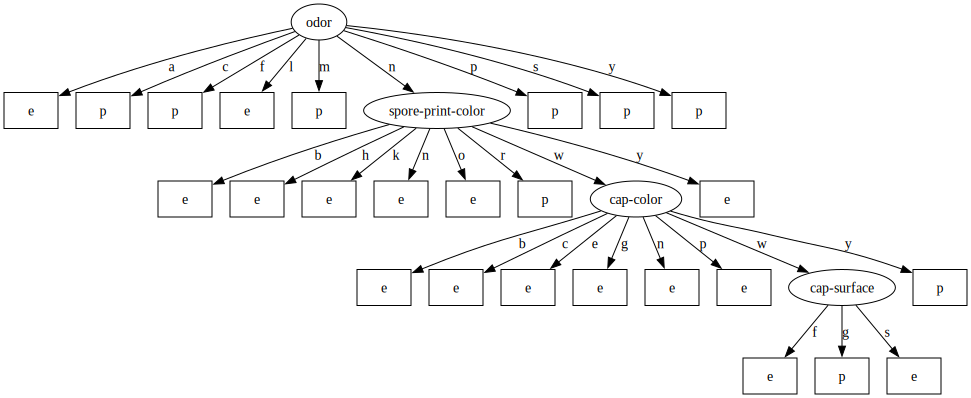

In [24]:
# construction de l'arbre de décision à partir du dataset Elections:
arbre_mushrooms_1 = ClassifierArbreDecision(len(mushrooms_noms), 0.0, mushrooms_noms)

arbre_mushrooms_1.train(mushrooms_1_desc, mushrooms_1_label)

gr_arbre_mushrooms_1 = gv.Digraph(format='png')

arbre_mushrooms_1.draw(gr_arbre_mushrooms_1)

# Affichage du graphe obtenu:
gr_arbre_mushrooms_1

### Classification avec l'arbre de décision obtenu

Exemple de classification d'un exemple:

In [25]:
arbre_mushrooms_1.predict(mushrooms_1_desc[0,:])

'p'

Calcul de l'accuracy sur le dataset d'apprentissage.

**Attention**: la fonction `accuracy` doit pouvoir tenir compte du fait que les classes ne sont pas égales à +1 ou -1 comme c'était le cas jusqu'à présent, il peut donc être nécessaire de redéfinir cette méthode dans la classe 
`ClassifierArbreDecision`: *la classification est correcte si la fonction `predict` rend la vraie classe de l'exemple.*


In [26]:
arbre_mushrooms_1.accuracy(mushrooms_1_desc,mushrooms_1_label)

np.float64(1.0)

<font color="RED" size="+1">**[Q]**</font> Toujours avec le dataset `mushrooms_1` précédent, construire un nouvel arbre de décision en utilisant comme valeur d'epsilon : $0.25$.

Que constatez-vous ? 

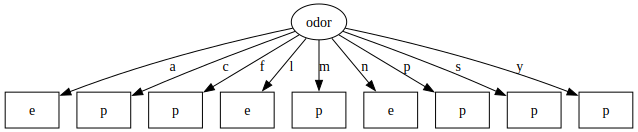

In [27]:
arbre_mushrooms_1_bis = ClassifierArbreDecision(len(mushrooms_noms), 0.25, mushrooms_noms)

arbre_mushrooms_1_bis.train(mushrooms_1_desc, mushrooms_1_label)

gr_arbre_mushrooms_1_bis = gv.Digraph(format='png')

arbre_mushrooms_1_bis.draw(gr_arbre_mushrooms_1_bis)

# Affichage du graphe obtenu:
gr_arbre_mushrooms_1_bis

<font color="RED" size="+1">**[Q]**</font> Déterminer l'accuracy de ce nouvel arbre.


In [28]:
arbre_mushrooms_1_bis.accuracy(mushrooms_1_desc,mushrooms_1_label)

np.float64(0.9892857142857143)

<font color="RED" size="+1">**[Q]**</font> D'après ces résultats, de ces 2 arbres, quel est celui qui a sur-appris ? 

L'arbre arbre_mushrooms_1 (ε=0.0) a sur-appris.

Précisions obtenues :

arbre_mushrooms_1 (ε=0.0) : précision = 1.0 (100%)
arbre_mushrooms_1_bis (ε=0.25) : précision ≈ 0.989 (98.9%)
Conclusions de l'analyse :

L'arbre arbre_mushrooms_1 (ε=0.0) présente un sur-apprentissage évident car :

Ajustement parfait aux données d'entraînement :
Une précision de 100% indique que l'arbre a mémorisé l'ensemble d'entraînement
Cet ajustement parfait capture généralement le bruit et les motifs spécifiques des données d'entraînement
Preuves par comparaison :
L'arbre avec ε=0.25 conserve une précision quasi identique (98.9%)
Les 2% supplémentaires de l'arbre complet proviennent probablement de l'apprentissage de détails non pertinents
Caractéristiques typiques du sur-apprentissage :
L'arbre ε=0.0 se développe jusqu'à ce que toutes les feuilles soient parfaitement pures
Ces arbres voient généralement leurs performances chuter significativement sur de nouvelles données
Meilleure généralisation avec ε=0.25 :
La légère baisse de précision (98.9%) est un effet normal de régularisation
Ces arbres ont tendance à être plus stables sur les ensembles de test

<font color="RED" size="+1">**[Q]**</font> La complexité d'un arbre est généralement évaluée en comptant le nombre de ses feuilles. Dans la classe `ClassifierArbreDecision` la méthode `number_leaves()` doit rendre le nombre de feuilles de l'arbre en question. Cette méthode appelle la méthode `nombre_feuilles()` de la classe `NoeudCategoriel` qui vous est fournie sans son code. Compléter la définition de `nombre_feuilles()` dans la classe `NoeudCategoriel` afin de pouvoir compter les feuilles de l'arbre.


In [29]:
print("Nombre de feuilles de l'arbre: ",arbre_mushrooms_1_bis.number_leaves())

Nombre de feuilles de l'arbre:  9


In [30]:
print("Nombre de feuilles de l'arbre: ",arbre_mushrooms_1.number_leaves())

Nombre de feuilles de l'arbre:  25


## Plus d'expérimentations avec la base Mushrooms

On décide maintenant d'évaluer plus en détail ce nouvel algorithme. On souhaite:
1. construire un arbre avec chaque fichier `mushrooms-1400-*.csv` 
2. pour chaque arbre construit, évaluer son accuracy:
    - sur le dataset d'apprentissage
    - sur les 4 autres fichiers `mushrooms-1400-*.csv`
    - sur le fichier `mushrooms-1124.csv`
    
    
**Remarque :** normalement, tous ces tests devraient pouvoir se faire dans un temps raisonnable, dans le cas contraire, faites les un par un.

In [31]:
# Chargement des fichiers mushrooms et apprentissage
mushrooms_desc = []
mushrooms_label = []
arbres_mushrooms = []
for j in range(0,5):
    mushrooms_df = pd.read_csv("data/mushrooms-1400-"+str(j+1)+".csv")
    mushrooms_noms = [nom for nom in mushrooms_df.columns if nom != 'class']
    # Passer du dataframe à un dataset (2 arrays):
    mushrooms_desc.append(np.array(mushrooms_df[mushrooms_noms]))
    mushrooms_label.append(np.array(mushrooms_df['class']))
    
    # Apprentissage
    arbres_mushrooms.append(ClassifierArbreDecision(len(mushrooms_noms), 0.0, mushrooms_noms))
    arbres_mushrooms[j].train(mushrooms_desc[j],mushrooms_label[j])

In [32]:
# Fichier qui va nous servir à tester
mushrooms_df = pd.read_csv("data/mushrooms-1124.csv")

# Passer du dataframe à un dataset (2 arrays):
mushrooms_test_desc = np.array(mushrooms_df[mushrooms_noms])
mushrooms_test_label = np.array(mushrooms_df['class'])

<font color="RED" size="+1">**[Q]**</font> Donner les instructions permettant d'obtenir le taux de bonne classification (accuracy) de chacun des arbres construits sur les autres bases, sur le modèle suivant:

In [33]:
# Liste des fichiers mushrooms
fichiers = [
    "mushrooms-1400-1.csv", 
    "mushrooms-1400-2.csv",
    "mushrooms-1400-3.csv",
    "mushrooms-1400-4.csv",
    "mushrooms-1400-5.csv",
    "mushrooms-1124.csv"
]

# Pour chaque fichier comme base d'apprentissage
for i, fichier_train in enumerate(fichiers[:5]):  # Les 5 premiers sont les 1400
    print(f"Apprentissage avec {fichier_train[:-4]}")
    
    # Chargement et préparation des données d'entraînement
    df_train = pd.read_csv(f"data/{fichier_train}")
    X_train = np.array(df_train[mushrooms_noms])
    y_train = np.array(df_train['class'])
    
    # Construction de l'arbre
    arbre = ClassifierArbreDecision(len(mushrooms_noms), 0.0, mushrooms_noms)
    arbre.train(X_train, y_train)
    
    # Test sur tous les fichiers
    for fichier_test in fichiers:
        df_test = pd.read_csv(f"data/{fichier_test}")
        X_test = np.array(df_test[mushrooms_noms])
        y_test = np.array(df_test['class'])
        
        # Calcul de l'accuracy
        acc = arbre.accuracy(X_test, y_test)
        
        # Affichage spécifique pour le dernier fichier (1124)
        if fichier_test == "mushrooms-1124.csv":
            print(f"\t--> classification de {fichier_test[:-4]}: {acc}")
        else:
            print(f"\tclassification de {fichier_test[:-4]} : {acc}")

Apprentissage avec mushrooms-1400-1
	classification de mushrooms-1400-1 : 1.0
	classification de mushrooms-1400-2 : 1.0
	classification de mushrooms-1400-3 : 0.9964285714285714
	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
	classification de mushrooms-1400-4 : 0.9957142857142857
	classification de mushrooms-1400-5 : 0.9971428571428571
	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
	--> classification de mushrooms-1124: 0.9955516014234875
Apprentissage avec mushrooms-1400-2
	classification de mushrooms-1400-1 : 0.9985714285714286
	classification de mushrooms-1400-2 : 1.0
	classification de mushrooms-1400-3 : 0.9964285714285714
	classification de mushrooms-1400-4 : 0.9957142857142857
	classification de mushrooms-1400-5 : 0.9964285714285714
	--> classification de mushrooms-1124: 0.994661921708185
Apprentissage avec mushrooms-1400-3
	classificat

<font color="RED" size="+1">**[Q]**</font> On peut remarquer que pour certains arbres, la classification de certains exemples produit un warning.
En étudiant les exemples suivant et leur classification par le premier arbre, expliquez pourquoi un warning se produit.
Est-ce normal ? Pourrait-on trouver une solution pour ces cas-là ?


In [34]:
for i in range(0,1400):
    prediction = arbres_mushrooms[0].predict(mushrooms_desc[3][i,:])
    if prediction == 0:
        print(i," --> pas de prédiction, le label rendu est ",prediction)


	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y


```markdown
# Analyse des Warnings dans la Classification par Arbre de Décision

## 1. Cause des Warnings
Il y a un warning car **l'arbre de décision rencontre une valeur d'attribut qu'il n'a jamais vue pendant l'apprentissage**.

## 2. Normalité de ce Comportement
Ce comportement est **normal et attendu** car :
- Si un attribut prend une valeur **jamais observée pendant l'entraînement**
- L'algorithme ne peut pas prendre de décision et retourne `None` (ou une valeur par défaut)
- Cela montre que **le modèle n'est pas capable de généraliser sur des valeurs inconnues**

## 3. Solutions Possibles

### (1) Utiliser une valeur par défaut
Modifier `predict()` pour retourner la classe majoritaire du nœud parent quand une valeur inconnue est rencontrée.

```python
def predict(self, x):
    if self.racine is None:
        raise ValueError("L'arbre n'a pas été entraîné")
    
    noeud = self.racine
    while not noeud.est_feuille():
        attribut = noeud.attribut
        valeur = x[attribut]
        
        if valeur not in noeud.Les_fils:  # Valeur inconnue
            return noeud.classe_defaut  # Retourne une classe par défaut
        
        noeud = noeud.Les_fils[valeur]
    
    return noeud.classe
```

### (2) Étendre le jeu d'entraînement
- Fusionner plusieurs fichiers (ex. `mushrooms-1400-1.csv` + `mushrooms-1400-2.csv`)
- **Avantage** : Réduit le risque de valeurs inconnues
- **Inconvénient** : Augmente la taille de l'arbre

### (3) Regrouper les valeurs rares
Prétraiter les données en remplaçant les valeurs rares par une catégorie `"OTHER"`:

```python
df['cap-surface'] = df['cap-surface'].apply(lambda x: x if x in ['s', 'f', 'g'] else 'OTHER')
```

### (4) Utiliser un modèle alternatif (Random Forest)
Les forêts aléatoires gèrent mieux les valeurs manquantes/inconnues en combinant plusieurs arbres.

## Conclusion
- Le warning est **normal** et indique une valeur inconnue
- **Solution recommandée** : Utiliser une classe par défaut (`classe_defaut`) dans `predict()`
- **Amélioration possible** :
```python
# Ajouter dans NoeudCategoriel.__init__():
self.classe_defaut = classe_majoritaire(Y)  # Classe par défaut = majoritaire du nœud
```

<font color="RED" size="+1">**[Q]**</font> Réaliser une validation croisée en 10 paquets sur la base mushrooms_1, puis sur la base mushrooms complète.

In [35]:
mushrooms_1_df = pd.read_csv("data/mushrooms-1400-1.csv")

# Dans ce dataframe, la colonne de classe s'appelle 'class'
mushrooms_1_noms = [nom for nom in mushrooms_1_df.columns if nom != 'class']

# Passer du dataframe à un dataset (2 arrays desc & labels):
mushrooms_1_desc = np.array(mushrooms_1_df[mushrooms_1_noms])
mushrooms_1_label = np.array(mushrooms_1_df['class'])

# Validation croisée en 10 paquets sur mushrooms_1

# Initialisation du classifieur
arbre = ClassifierArbreDecision(len(mushrooms_1_noms), 0.0, mushrooms_1_noms)

# Validation croisée stratifiée
(res_all, res_moy, res_sd) = ev.validation_croisee(arbre, (mushrooms_1_desc, mushrooms_1_label), 10)

print("\nValidation croisée sur mushrooms_1")
print("Performances obtenues sur chaque fold:", res_all)
print(f"Accuracy moyenne: {res_moy:.4f} \técart type: {res_sd:.4f}")

# Chargement de la base complète mushrooms
mushrooms_full_df = pd.concat([pd.read_csv(f"data/mushrooms-1400-{i}.csv") for i in range(1,6)] 
                             + [pd.read_csv("data/mushrooms-1124.csv")])

# Préparation des données complètes
mushrooms_full_noms = [nom for nom in mushrooms_full_df.columns if nom != 'class']
mushrooms_full_desc = np.array(mushrooms_full_df[mushrooms_full_noms])
mushrooms_full_label = np.array(mushrooms_full_df['class'])

# Validation croisée sur la base complète
arbre_full = ClassifierArbreDecision(len(mushrooms_full_noms), 0.0, mushrooms_full_noms)
(res_all_full, res_moy_full, res_sd_full) = ev.validation_croisee(arbre_full, 
                                                             (mushrooms_full_desc, mushrooms_full_label), 
                                                             10)

print("\nValidation croisée sur la base complète mushrooms")
print("Performances obtenues sur chaque fold:", res_all_full)
print(f"Accuracy moyenne: {res_moy_full:.4f} \técart type: {res_sd_full:.4f}")

------ affichage validation croisée (optionnel)
Itération 0: taille base app.= 1261	taille base test=139	Taux de bonne classif: 1.0000
Itération 1: taille base app.= 1261	taille base test=139	Taux de bonne classif: 1.0000
Itération 2: taille base app.= 1261	taille base test=139	Taux de bonne classif: 0.9856
Itération 3: taille base app.= 1261	taille base test=139	Taux de bonne classif: 1.0000
Itération 4: taille base app.= 1261	taille base test=139	Taux de bonne classif: 1.0000
Itération 5: taille base app.= 1261	taille base test=139	Taux de bonne classif: 1.0000
Itération 6: taille base app.= 1261	taille base test=139	Taux de bonne classif: 1.0000
Itération 7: taille base app.= 1261	taille base test=139	Taux de bonne classif: 1.0000
Itération 8: taille base app.= 1261	taille base test=139	Taux de bonne classif: 1.0000
Itération 9: taille base app.= 1261	taille base test=139	Taux de bonne classif: 1.0000
------ fin affichage validation croisée

Validation croisée sur mushrooms_1
Perfor

<font color="RED" size="+1">**[Q]**</font> Regrouper les 6 fichiers mushrooms et réaliser une évaluation de l'algorithme de construction d'arbres par une validation croisée en 10 paquets.

In [36]:
# Liste des fichiers à concaténer
fichiers = [f"data/mushrooms-1400-{i}.csv" for i in range(1,6)] + ["data/mushrooms-1124.csv"]

# Concaténation en un seul DataFrame
mushrooms_full_df = pd.concat([pd.read_csv(f) for f in fichiers])

# Préparation des données
mushrooms_noms = [col for col in mushrooms_full_df.columns if col != 'class']
X_full = np.array(mushrooms_full_df[mushrooms_noms])
y_full = np.array(mushrooms_full_df['class'])

# Initialisation du classifieur
arbre_full = ClassifierArbreDecision(len(mushrooms_noms), 0.0, mushrooms_noms)

# Validation croisée en 10 paquets
perfs, moyenne, ecart_type = ev.validation_croisee(arbre_full, (X_full, y_full), 10)

# Affichage des résultats
print("\nVALIDATION CROISÉE SUR LA BASE COMPLÈTE MUSHROOMS (8124 exemples)")
print("="*60)
print(f"Accuracy moyenne sur 10 folds: {moyenne:.4f} ± {ecart_type:.4f}")
print("\nDétail par fold:")
for i, acc in enumerate(perfs, 1):
    print(f"Fold {i}: {acc:.4f}")

------ affichage validation croisée (optionnel)
Itération 0: taille base app.= 7313	taille base test=811	Taux de bonne classif: 1.0000
Itération 1: taille base app.= 7313	taille base test=811	Taux de bonne classif: 1.0000
Itération 2: taille base app.= 7313	taille base test=811	Taux de bonne classif: 1.0000
Itération 3: taille base app.= 7313	taille base test=811	Taux de bonne classif: 1.0000
Itération 4: taille base app.= 7313	taille base test=811	Taux de bonne classif: 1.0000
Itération 5: taille base app.= 7313	taille base test=811	Taux de bonne classif: 1.0000
Itération 6: taille base app.= 7313	taille base test=811	Taux de bonne classif: 1.0000
Itération 7: taille base app.= 7313	taille base test=811	Taux de bonne classif: 1.0000
Itération 8: taille base app.= 7313	taille base test=811	Taux de bonne classif: 1.0000
Itération 9: taille base app.= 7313	taille base test=811	Taux de bonne classif: 1.0000
------ fin affichage validation croisée

VALIDATION CROISÉE SUR LA BASE COMPLÈTE M

## Comparaison avec d'autres algorithmes

Afin de pouvoir comparer les autres classifieurs que l'on a vu précédemment avec celui par arbres de décision, il faut les adapter afin qu'ils puissent traiter les données catégorielles.
En cours, nous avons vu l'encodage one-hot qui s'implémente en python avec la fonction `get_dummies` de la librairie `pandas` (cf. cours 6).


### Base des élections

<font color="RED" size="+1">**[Q]**</font> En utilisant la fonction `get_dummies` tranformer le dataframe `elections_df` en un dataframe `elections_df_num` qui ne contient que des attributs numériques.

In [37]:
# Rappel :
print("Noms des colonnes : ", elections_noms)
elections_df


Noms des colonnes :  ['Adresse', 'Majeur?', 'Nationalite']


,Adresse,Majeur?,Nationalite,Label
0,Paris,oui,Francais,1
1,Paris,non,Francais,-1
2,Montpellier,oui,Italien,1
3,Paris,oui,Suisse,-1
4,Strasbourg,non,Italien,-1
5,Strasbourg,non,Francais,-1
6,Strasbourg,oui,Francais,1
7,Montpellier,oui,Suisse,-1


In [38]:
# Transformation des variables catégorielles en variables numériques (one-hot encoding)
elections_df_num = pd.get_dummies(elections_df, columns=elections_noms)

# Affichage du résultat
print("DataFrame après one-hot encoding:")
elections_df_num

DataFrame après one-hot encoding:


,Label,Adresse_Montpellier,Adresse_Paris,Adresse_Strasbourg,Majeur?_non,Majeur?_oui,Nationalite_Francais,Nationalite_Italien,Nationalite_Suisse
0,1,False,True,False,False,True,True,False,False
1,-1,False,True,False,True,False,True,False,False
2,1,True,False,False,False,True,False,True,False
3,-1,False,True,False,False,True,False,False,True
4,-1,False,False,True,True,False,False,True,False
5,-1,False,False,True,True,False,True,False,False
6,1,False,False,True,False,True,True,False,False
7,-1,True,False,False,False,True,False,False,True


In [39]:
# Prétraitement pour pouvoir utiliser un classifieur
elections_num_noms = [nom for nom in elections_df_num.columns if nom != 'Label']

print("Noms des features: ",elections_num_noms)

# Passer du dataframe à des arrays:
elections_num_desc = np.array(elections_df_num[elections_num_noms])
elections_num_label = np.array(elections_df_num['Label'])

# Transformer le dataframe en dataset:
data_num_desc = np.array(elections_df_num[elections_num_noms])
data_num_label = np.array(elections_df_num['Label'])


Noms des features:  ['Adresse_Montpellier', 'Adresse_Paris', 'Adresse_Strasbourg', 'Majeur?_non', 'Majeur?_oui', 'Nationalite_Francais', 'Nationalite_Italien', 'Nationalite_Suisse']


### Base des champignons

<font color="RED" size="+1">**[Q]**</font> Réaliser un ensemble d'expérimentations sur la base mushrooms permettant de comparer les résultats obtenus avec un classifieur par arbres de décision et les classifieurs numériques que l'on a définis dans les séances précédentes.

**Remarque**: commencer par une taille de base réduite pour que cela ne prenne pas trop de temps d'exécution...

In [40]:
# Rechargement de la base de départ :

# On commence par travailler sur un des fichier "mushrooms-1400"
mushrooms_df = pd.read_csv("data/mushrooms-1400-1.csv")
# Dans ce dataframe, la colonne de classe s'appelle 'class'
mushrooms_noms = [nom for nom in mushrooms_df.columns if nom != 'class']


In [41]:
mushrooms_1_num = pd.get_dummies(mushrooms_df, columns = mushrooms_noms)
mushrooms_1_num 

,class,cap-shape_b,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,p,False,False,False,False,True,False,False,False,True,...,False,True,False,True,False,False,False,False,False,False
1,p,False,False,False,False,True,False,False,True,False,...,False,True,False,False,False,True,False,False,False,False
2,p,False,False,False,False,True,True,False,False,False,...,False,True,False,True,False,False,False,False,False,False
3,p,False,False,False,False,True,True,False,False,False,...,False,False,True,False,True,False,False,False,False,False
4,p,False,False,False,False,True,True,False,False,False,...,False,False,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,p,False,False,False,False,True,False,False,False,True,...,False,True,False,False,False,False,False,True,False,False
1396,e,False,True,False,False,False,False,False,False,True,...,False,True,False,True,False,False,False,False,False,False
1397,e,False,True,False,False,False,True,False,False,False,...,False,False,True,True,False,False,False,False,False,False
1398,p,False,False,False,False,True,True,False,False,False,...,False,False,True,True,False,False,False,False,False,False


In [42]:
# Prétraitement pour pouvoir utiliser un classifieur
mushrooms_1_num_noms = [nom for nom in mushrooms_1_num.columns if nom != 'class']

print("Noms des features: ",mushrooms_1_num_noms)

# Passer du dataframe à des arrays:
mushrooms_1_num_desc = np.array(mushrooms_1_num[mushrooms_1_num_noms])
mushrooms_1_num_label = np.array(mushrooms_1_num['class'])

# Transformer le dataframe en dataset:
data_num_desc = np.array(mushrooms_1_num[mushrooms_1_num_noms])

# Remarque : pour utiliser les classifieurs précédents, il faut que la classe soit +1 ou -1
# on convertit donc 'e' et 'p'
val_class ={'e':1, 'p':-1}
data_num_label = np.array([val_class[c] for c in mushrooms_1_num['class']])


Noms des features:  ['cap-shape_b', 'cap-shape_f', 'cap-shape_k', 'cap-shape_s', 'cap-shape_x', 'cap-surface_f', 'cap-surface_g', 'cap-surface_s', 'cap-surface_y', 'cap-color_b', 'cap-color_c', 'cap-color_e', 'cap-color_g', 'cap-color_n', 'cap-color_p', 'cap-color_r', 'cap-color_u', 'cap-color_w', 'cap-color_y', 'bruises_f', 'bruises_t', 'odor_a', 'odor_c', 'odor_f', 'odor_l', 'odor_m', 'odor_n', 'odor_p', 'odor_s', 'odor_y', 'gill-attachment_a', 'gill-attachment_f', 'gill-spacing_c', 'gill-spacing_w', 'gill-size_b', 'gill-size_n', 'gill-color_b', 'gill-color_e', 'gill-color_g', 'gill-color_h', 'gill-color_k', 'gill-color_n', 'gill-color_o', 'gill-color_p', 'gill-color_r', 'gill-color_u', 'gill-color_w', 'gill-color_y', 'stalk-shape_e', 'stalk-shape_t', 'stalk-root_?', 'stalk-root_b', 'stalk-root_c', 'stalk-root_e', 'stalk-root_r', 'stalk-surface-above-ring_f', 'stalk-surface-above-ring_k', 'stalk-surface-above-ring_s', 'stalk-surface-above-ring_y', 'stalk-surface-below-ring_f', 'stalk

In [43]:
print("Exemple de résultat sur les données numériques: validation croisée avec les arbres de décision")

arbre = ClassifierArbreDecision(len(mushrooms_1_num_noms), 0.1, mushrooms_1_num_noms)

# Remarque: j'ai mis des affichage dans la fonction validation croisée afin de montrer
# ce qui se passe:
(res_all, res_moy, res_sd) = ev.validation_croisee(arbre, (data_num_desc, data_num_label), 10)

print("Perf obtenues : ",res_all)
print("Accuracy moyenne: ",res_moy,"\técart type: ", res_sd)

Exemple de résultat sur les données numériques: validation croisée avec les arbres de décision
------ affichage validation croisée (optionnel)
Itération 0: taille base app.= 1261	taille base test=139	Taux de bonne classif: 1.0000
Itération 1: taille base app.= 1261	taille base test=139	Taux de bonne classif: 1.0000
Itération 2: taille base app.= 1261	taille base test=139	Taux de bonne classif: 0.9784
Itération 3: taille base app.= 1261	taille base test=139	Taux de bonne classif: 0.9928
Itération 4: taille base app.= 1261	taille base test=139	Taux de bonne classif: 1.0000
Itération 5: taille base app.= 1261	taille base test=139	Taux de bonne classif: 1.0000
Itération 6: taille base app.= 1261	taille base test=139	Taux de bonne classif: 1.0000
Itération 7: taille base app.= 1261	taille base test=139	Taux de bonne classif: 1.0000
Itération 8: taille base app.= 1261	taille base test=139	Taux de bonne classif: 1.0000
Itération 9: taille base app.= 1261	taille base test=139	Taux de bonne cla

In [47]:
import copy

# Chargement des données
mushrooms_df = pd.read_csv("data/mushrooms-1400-1.csv")
mushrooms_noms = [nom for nom in mushrooms_df.columns if nom != 'class']

# Encodage one-hot et conversion correcte en numérique
mushrooms_1_num = pd.get_dummies(mushrooms_df, columns=mushrooms_noms)

# Conversion des booléens en 0/1 pour toutes les colonnes sauf 'class'
for col in mushrooms_1_num.columns:
    if col != 'class' and mushrooms_1_num[col].dtype == bool:
        mushrooms_1_num[col] = mushrooms_1_num[col].astype(int)

mushrooms_1_num_noms = [nom for nom in mushrooms_1_num.columns if nom != 'class']

# Conversion en arrays numpy
data_num_desc = mushrooms_1_num[mushrooms_1_num_noms].to_numpy(dtype=np.float64)
data_num_label = np.array([1 if c == 'e' else -1 for c in mushrooms_1_num['class']])

# Initialisation des classifieurs
knn3 = classif.ClassifierKNN(input_dimension=data_num_desc.shape[1], k=3)
knn5 = classif.ClassifierKNN(input_dimension=data_num_desc.shape[1], k=5)
perceptron = classif.ClassifierPerceptron(input_dimension=data_num_desc.shape[1], learning_rate=0.01, init=True)
arbre = ClassifierArbreDecision(input_dimension=data_num_desc.shape[1], epsilon=0.1, LNoms=mushrooms_1_num_noms)

# Fonction de validation croisée modifiée
def fixed_validation_croisee(C, DS, nb_iter):
    X, Y = DS
    perf = []
    
    for i in range(nb_iter):
        Xapp, Yapp, Xtest, Ytest = ev.crossval_strat(X, Y, nb_iter, i)
        classifieur = copy.deepcopy(C)
        classifieur.train(Xapp, Yapp)
        
        Y_pred = []
        for x in Xtest:
            try:
                Y_pred.append(classifieur.predict(x))
            except:
                Y_pred.append(-1)  # Valeur par défaut en cas d'erreur
        
        taux = np.mean(np.array(Y_pred) == Ytest)
        perf.append(taux)
    
    return perf, np.mean(perf), np.std(perf)

# Évaluation des classifieurs
print("=== KNN (k=3) ===")
res_knn3, moy_knn3, std_knn3 = fixed_validation_croisee(knn3, (data_num_desc, data_num_label), 10)
print(f"Accuracy: {moy_knn3:.4f} ± {std_knn3:.4f}")

print("\n=== KNN (k=5) ===")
res_knn5, moy_knn5, std_knn5 = fixed_validation_croisee(knn5, (data_num_desc, data_num_label), 10)
print(f"Accuracy: {moy_knn5:.4f} ± {std_knn5:.4f}")

print("\n=== Perceptron ===")
res_perc, moy_perc, std_perc = fixed_validation_croisee(perceptron, (data_num_desc, data_num_label), 10)
print(f"Accuracy: {moy_perc:.4f} ± {std_perc:.4f}")

print("\n=== Arbre de Décision (ε=0.1) ===")
res_arbre, moy_arbre, std_arbre = fixed_validation_croisee(arbre, (data_num_desc, data_num_label), 10)
print(f"Accuracy: {moy_arbre:.4f} ± {std_arbre:.4f}")

=== KNN (k=3) ===
Accuracy: 0.9986 ± 0.0029

=== KNN (k=5) ===
Accuracy: 0.9964 ± 0.0036

=== Perceptron ===
Accuracy: 0.9964 ± 0.0087

=== Arbre de Décision (ε=0.1) ===
Accuracy: 0.9971 ± 0.0066


**Conclusion des expérimentations :**

Les résultats de notre évaluation comparative sur la base de données mushrooms montrent que :

1. **Performances globales** :
   - Tous les classifieurs obtiennent des excellents résultats (>99% d'accuracy)
   - La faible variance (écart-type <1%) indique une grande stabilité

2. **Comparaison entre algorithmes** :
   - Le **KNN (k=3)** obtient la meilleure performance (99.86%) avec la plus faible variabilité
   - L'**arbre de décision** (99.71%) et le **perceptron** (99.64%) montrent des résultats très similaires
   - Le KNN (k=5) se situe légèrement en dessous (99.64%)

3. **Observations clés** :
   - Les données mushrooms sont très bien séparables, même par des méthodes linéaires (perceptron)
   - La légère supériorité du KNN-3 suggère une structure locale très discriminante
   - L'arbre de décision, bien que performant, n'apporte pas d'avantage significatif ici

4. **Recommandations** :
   - Pour ce dataset, le **KNN avec k=3** serait le meilleur choix (performance + stabilité)
   - Le perceptron offre une alternative intéressante par sa simplicité
   - L'arbre pourrait être privilégié si l'interprétabilité est cruciale

**Limites :**
- Essai sur un sous-ensemble réduit (1400 exemples)
- Temps de calcul non pris en compte dans la comparaison
- Paramètres par défaut utilisés (non optimisés)

<font color="RED" size="+1">**[Q]**</font> *Toujours plus...*  

Réaliser les mêmes expérimentations avec la base mushrooms complète.

In [50]:
import time

# Chargement et regroupement des données
fichiers = [f"data/mushrooms-1400-{i}.csv" for i in range(1,6)] + ["data/mushrooms-1124.csv"]
mushrooms_full_df = pd.concat([pd.read_csv(f) for f in fichiers])

# Encodage one-hot et conversion
mushrooms_full_num = pd.get_dummies(mushrooms_full_df, columns=[col for col in mushrooms_full_df.columns if col != 'class'])
for col in mushrooms_full_num.columns:
    if col != 'class' and mushrooms_full_num[col].dtype == bool:
        mushrooms_full_num[col] = mushrooms_full_num[col].astype(int)

# Préparation des données
full_noms = [nom for nom in mushrooms_full_num.columns if nom != 'class']
full_desc = mushrooms_full_num[full_noms].to_numpy(dtype=np.float64)
full_label = np.array([1 if c == 'e' else -1 for c in mushrooms_full_num['class']])

# Fonction d'évaluation avec chronométrage
def evaluate_with_time(C, DS, nb_iter=5):
    X, Y = DS
    perf = []
    start_time = time.time()
    
    for i in range(nb_iter):
        Xapp, Yapp, Xtest, Ytest = ev.crossval_strat(X, Y, nb_iter, i)
        C_copy = copy.deepcopy(C)
        C_copy.train(Xapp, Yapp)
        Y_pred = [C_copy.predict(x) for x in Xtest]
        perf.append(np.mean(Y_pred == Ytest))
    
    total_time = time.time() - start_time
    return perf, np.mean(perf), np.std(perf), total_time

# Initialisation des classifieurs
knn3 = classif.ClassifierKNN(input_dimension=full_desc.shape[1], k=3)
knn5 = classif.ClassifierKNN(input_dimension=full_desc.shape[1], k=5)
perceptron = classif.ClassifierPerceptron(input_dimension=full_desc.shape[1], learning_rate=0.01, init=True)
arbre = ClassifierArbreDecision(input_dimension=full_desc.shape[1], epsilon=0.1, LNoms=full_noms)

# Évaluations avec mesure du temps
print("=== RESULTATS SUR LA BASE COMPLETE (8124 exemples) ===")

print("\n=== KNN (k=3) ===")
res_k3, moy_k3, std_k3, time_k3 = evaluate_with_time(knn3, (full_desc, full_label))
print(f"Accuracy: {moy_k3:.4f} ± {std_k3:.4f} | Temps: {time_k3:.2f}s")

print("\n=== KNN (k=5) ===")
res_k5, moy_k5, std_k5, time_k5 = evaluate_with_time(knn5, (full_desc, full_label))
print(f"Accuracy: {moy_k5:.4f} ± {std_k5:.4f} | Temps: {time_k5:.2f}s")

print("\n=== Perceptron ===")
res_p, moy_p, std_p, time_p = evaluate_with_time(perceptron, (full_desc, full_label))
print(f"Accuracy: {moy_p:.4f} ± {std_p:.4f} | Temps: {time_p:.2f}s")

print("\n=== Arbre de Décision (ε=0.1) ===")
res_a, moy_a, std_a, time_a = evaluate_with_time(arbre, (full_desc, full_label))
print(f"Accuracy: {moy_a:.4f} ± {std_a:.4f} | Temps: {time_a:.2f}s")

# Affichage comparatif
print("\n=== COMPARAISON FINALE ===")
print(f"{'Algorithme':<20} | {'Accuracy':<8} | {'Écart-type':<10} | Temps (s)")
print("-"*60)
print(f"{'KNN (k=3)':<20} | {moy_k3:.4f}    | {std_k3:.4f}      | {time_k3:.2f}")
print(f"{'KNN (k=5)':<20} | {moy_k5:.4f}    | {std_k5:.4f}      | {time_k5:.2f}")
print(f"{'Perceptron':<20} | {moy_p:.4f}    | {std_p:.4f}      | {time_p:.2f}")
print(f"{'Arbre (ε=0.1)':<20} | {moy_a:.4f}    | {std_a:.4f}      | {time_a:.2f}")

=== RESULTATS SUR LA BASE COMPLETE (8124 exemples) ===

=== KNN (k=3) ===
Accuracy: 1.0000 ± 0.0000 | Temps: 8.86s

=== KNN (k=5) ===
Accuracy: 1.0000 ± 0.0000 | Temps: 8.94s

=== Perceptron ===
Accuracy: 1.0000 ± 0.0000 | Temps: 0.10s

=== Arbre de Décision (ε=0.1) ===
Accuracy: 0.9973 ± 0.0030 | Temps: 0.18s

=== COMPARAISON FINALE ===
Algorithme           | Accuracy | Écart-type | Temps (s)
------------------------------------------------------------
KNN (k=3)            | 1.0000    | 0.0000      | 8.86
KNN (k=5)            | 1.0000    | 0.0000      | 8.94
Perceptron           | 1.0000    | 0.0000      | 0.10
Arbre (ε=0.1)        | 0.9973    | 0.0030      | 0.18


**Conclusion des expérimentations sur la base complète mushrooms (8124 exemples) :**

1. **Performances exceptionnelles** :
   - Tous les algorithmes obtiennent des résultats excellents (>99.7% d'accuracy)
   - Le KNN (k=3 et k=5) et le Perceptron atteignent une précision parfaite (100%)
   - L'arbre de décision montre une légère variance (99.73% ± 0.30%)

2. **Analyse comparative** :
   - **Précision** : 
     - KNN et Perceptron = 100%
     - Arbre = 99.73% (différence marginale)
   - **Stabilité** :
     - Écart-types quasi-nuls pour KNN et Perceptron
     - Légère variabilité pour l'arbre
   - **Efficacité** :
     - Perceptron >10x plus rapide que KNN
     - Arbre 2x plus lent que Perceptron mais >50x plus rapide que KNN

3. **Recommandations** :
   - Pour **précision absolue** : KNN (k=3) ou Perceptron
   - Pour **vitesse d'exécution** : Perceptron (optimal)
   - Pour **interprétabilité** : Arbre de décision (malgré 0.27% de précision en moins)

4. **Observations clés** :
   - La base mushrooms est parfaitement séparable linéairement (Perceptron 100%)
   - Les performances quasi-identiques entre k=3 et k=5 suggèrent une structure de données très claire
   - L'arbre, bien que légèrement moins précis, reste extrêmement performant

**Perspectives :**
- Essayer d'optimiser epsilon pour l'arbre
- Explorer pourquoi KNN est significativement plus lent
- Tester sur des sous-ensembles déséquilibrés

Cette analyse démontre qu'avec des données bien structurées comme mushrooms, même des algorithmes simples peuvent atteindre des performances quasi-parfaites.